# Exercise 1

Use the requests module (or urllib) to use the Entrez API (see slides 5Actions ) to identify the PubMed IDs for 1000 Alzheimers papers from 2022 and for 1000 cancer papers from 2022. (9 points)

Note: To search for a disease and a publication year, structure the term like: Alzheimers+AND+2022[pdat] (Here [pdat] indicates that this is a publication year, and the AND (has to be all caps) means both conditions should apply.) 

Use the Entrez API via requests/urllib to pull the metadata for each such paper found above (both cancer and Alzheimers) (and save a JSON file storing each paper's title, abstract, and the query that found it that is of the general form: (12 points) 

In [7]:
from Bio import Entrez
Entrez.email = "taiebben5@gmail.com"
handle = Entrez.esearch(db="pubmed", term="Alzheimers AND 2022[pdat]", retmax=1000)
record_1 = Entrez.read(handle)
id_ = record_1["IdList"]
len(id_)

1000

In [8]:
handle = Entrez.esearch(db="pubmed", term="cancer AND 2022[pdat]", retmax=1000)
record = Entrez.read(handle)
id_list = record["IdList"]
len(id_list)

1000

In [9]:
record_1['TranslationSet']

[{'From': 'Alzheimers', 'To': '"alzheimer disease"[MeSH Terms] OR ("alzheimer"[All Fields] AND "disease"[All Fields]) OR "alzheimer disease"[All Fields] OR "alzheimers"[All Fields]'}]

In [10]:
import numpy as np
import requests
import xml.dom.minidom as m
from tqdm import tqdm

def get_info(pmid):
    r = requests.get(
    "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    f"efetch.fcgi?db=pubmed&retmode=xml&id={pmid}"
  )
    doc = m.parseString(r.text)
    titles = doc.getElementsByTagName("ArticleTitle")
    abstracts = doc.getElementsByTagName("AbstractText")
    title = titles[0].childNodes[0].wholeText
    abstract = abstracts[0].childNodes[0].wholeText
    return title, abstract

In [11]:
import time
from tqdm import tqdm
if __name__ == "__main__":
    t = []
    r = []
    v=[]
    q=[]
    for i in tqdm(np.arange(0,1000)):
        try:
            title, abstract = get_info(id_list[i])
            t.append(title)
            r.append(abstract)
            v.append(id_list[i])
            q.append(record['TranslationSet'])
            time.sleep(1)
            title, abstract = get_info(id_[i])
            t.append(title)
            r.append(abstract)
            v.append(id_[i])
            q.append(record_1['TranslationSet'])
        except:
            pass

100%|███████████████████████████████████████| 1000/1000 [25:11<00:00,  1.51s/it]


In [116]:
import json
import pandas as pd
 
dictionary = {}
for i in range(0,len(v)):
    dictionary[v[i]] = [{'ArticleTitle' : t[i],
                      'AbstractText' : r[i],
                      'query' : q[i][0]}]
    
json_object = json.dumps(dictionary, indent=2)

with open("sample.json", "w") as outfile:
    outfile.write(json_object)

There are of course many more papers of each category, but is there any overlap in the two sets of papers that you identified? (3 points)

In [472]:
l1=[]
for i in v:
    if i not in l1:
        l1.append(i)
    else:
        print(i,end=' ')

for i in t:
    if i not in l1:
        l1.append(i)
    else:
        print(i,end=' ')
        
for i in r:
    if i not in l1:
        l1.append(i)
    else:
        print(i,end=' ')

36314209 Hypothalamic Functional Connectivity and Apathy in People with Alzheimer's Disease and Cognitively Normal Healthy Controls. Earlier studies have described the neural markers of apathy in Alzheimer's disease (AD) and mild cognitive impairment (MCI), but few focused on the motivation circuits. Here, we targeted hypothalamus, a hub of the motivation circuit. CXCR5 Nicotinamide  

There is one overlap in the two sets which is PMID: 36314209

 Discuss any pros or cons of your choice in your readme (1 point).

The method used above works well but is quite long and fastidious. Only 1639 out of 2002 possible results have been outputed in the json file. This is due to the fact that some abstracts are in itallique and it doesen't work well with .get. For this reason, I used the method (try: / except:) within the for loop to continue looping even if an error occured. Another method would have been to get the results in a more elegant and faster way by using post instead of get and ET.tostring(item, method="text").decode() instead of text to overcome the issues previoulsy encountered.

# Exercise 2

Machine learning and data visualization strategies generally work best on data that is numeric, but exercise 1 gave us text data, and indeed text is common. Fortunately, modern NLP algorithms powered by machine learning trained on massive datasets exist that can take words (e.g. word2vec) or titles and abstracts (e.g. SPECTER) and return a vector of numbers in a way that similar items are given similar vectors. Since we have titles and abstracts, let's use SPECTER.

In particular, for each paper identified from exercise 1, compute the SPECTER embedding (a 768-dimensional vector). Keep track of which papers came from searching for Alzheimers, which came from searching for cancer. (5 points) If you are familiar with SPECTER and wish to do it another way, that's great, if not here's one approach based on https://github.com/allenai/specter:

Install pytorch (a deep learning library) by following the instructions here: https://pytorch.org/get-started/locally/

Install the huggingface transformers module: pip install transformers

(🤗 huggingface provides access to a number of pre-trained NLP language models.)

Have your code load the SPECTER model (the first time you do this, it will take a bit to download the model; it will be stored locally for fast reuse later):

In [163]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

In [249]:
paper_ = {}
for i in range(0,len(v)):
    paper_[v[i]] = {'ArticleTitle' : t[i],
                      'AbstractText' : r[i],
                      'query' : q[i]}

In [293]:
import tqdm

# we can use a persistent dictionary (via shelve) so we can stop and restart if needed
# alternatively, do the same but with embeddings starting as an empty dictionary
embeddings = {}
for pmid, paper in tqdm.tqdm(paper_.items()):
    data = [paper["ArticleTitle"] + tokenizer.sep_token + paper["AbstractText"]]
    inputs = tokenizer(
        data, padding=True, truncation=True, return_tensors="pt", max_length=512
    )
    result = model(**inputs)
    # take the first token in the batch as the embedding
    embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]

# turn our dictionary into a list
embeddings = [embeddings[pmid] for pmid in paper_.keys()]

100%|███████████████████████████████████████| 1665/1665 [09:40<00:00,  2.87it/s]


In [295]:
len(embeddings[1])

768

Here, we can see that so far embeddings[i] is the 768-dim vector for the ith paper

Keep track of which papers came from searching for Alzheimers, which came from searching for cancer. (5 points)

In the method I used, it is quite eqsy to keep trach of the papers that came from query Alzheimer: it represents all the odd numbers whereas all the articles that came from Cancer are the even number. However, below I use a computing method to keep track of the initial query by representing the query either with a 0 or a 1. (N.B.: I could have used get_dummies but I used a for loop).

Apply principal component analysis (PCA) to identify the first three principal components. (5 points) I suggest using the sklearn module, e.g.

In [477]:
## from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
    pca.fit_transform(embeddings),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_pca["query"] = [str(paper["query"]) for paper in paper_.values()]
embeddings_pca

,PC0,PC1,PC2,query
0,6.554755,-0.056561,-0.790346,"[{'From': 'cancer', 'To': '""neoplasms""[MeSH Te..."
1,-4.988945,4.661712,1.788054,"[{'From': 'Alzheimers', 'To': '""alzheimer dise..."
2,6.545237,2.555388,-1.877077,"[{'From': 'cancer', 'To': '""neoplasms""[MeSH Te..."
3,-6.343323,2.492526,-2.669444,"[{'From': 'Alzheimers', 'To': '""alzheimer dise..."
4,9.492308,3.271528,1.208662,"[{'From': 'cancer', 'To': '""neoplasms""[MeSH Te..."
...,...,...,...,...
1660,2.935706,-0.074439,2.934988,"[{'From': 'cancer', 'To': '""neoplasms""[MeSH Te..."
1661,-3.921465,5.087469,3.117099,"[{'From': 'Alzheimers', 'To': '""alzheimer dise..."
1662,2.751323,-4.223389,6.385440,"[{'From': 'cancer', 'To': '""neoplasms""[MeSH Te..."
1663,-5.143861,6.226035,2.286060,"[{'From': 'Alzheimers', 'To': '""alzheimer dise..."


Plot 2D scatter plots for PC0 vs PC1, PC0 vs PC2, and PC1 vs PC2; color code these by the search query used (Alzheimers vs cancer). (5 points) Comment on the separation or lack thereof, and any take-aways from that. (5 points)

In [480]:
for i in range (len(embeddings_pca["query"])):
    if ('cancer' in embeddings_pca["query"][i]) == True:
        embeddings_pca["query"][i] = 0
    else: 
        embeddings_pca["query"][i] = 1

/var/folders/y2/1dl6h43j0_90w0m04wnk0yf80000gn/T/ipykernel_16893/3250214865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embeddings_pca["query"][i] = 0
/var/folders/y2/1dl6h43j0_90w0m04wnk0yf80000gn/T/ipykernel_16893/3250214865.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embeddings_pca["query"][i] = 1


In [410]:
embeddings_pca

,PC0,PC1,PC2,query
0,6.554755,-0.056548,-0.790179,0
1,-4.988945,4.661979,1.787722,1
2,6.545237,2.555237,-1.877547,0
3,-6.343323,2.492340,-2.669711,1
4,9.492308,3.272102,1.204908,0
...,...,...,...,...
1660,2.935706,-0.073953,2.933591,0
1661,-3.921465,5.087844,3.116673,1
1662,2.751323,-4.223462,6.386106,0
1663,-5.143861,6.226165,2.286926,1


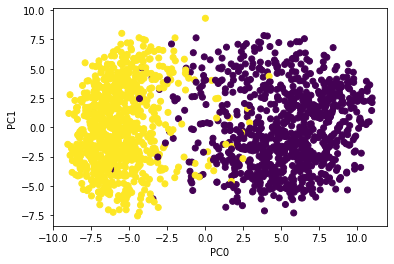

In [413]:
import matplotlib.pyplot as plt
plt.scatter(embeddings_pca.iloc[:, 0], embeddings_pca.iloc[:, 1], c = embeddings_pca["query"])
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.show()

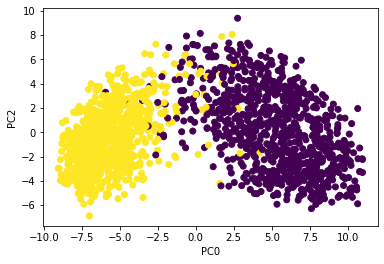

In [415]:
plt.scatter(embeddings_pca.iloc[:, 0], embeddings_pca.iloc[:, 2], c = embeddings_pca["query"])
plt.xlabel('PC0')
plt.ylabel('PC2')
plt.show()

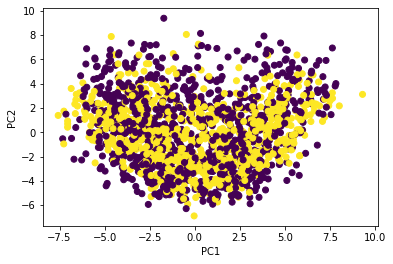

In [416]:
plt.scatter(embeddings_pca.iloc[:, 1], embeddings_pca.iloc[:, 2], c = embeddings_pca["query"])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Comment on the separation or lack thereof, and any take-aways from that

There is a clear separation for PC0 vs. PC1 and PC0 vs. PC2. However, there is a lot of overlapping using PC1 vs. PC2. The lack of separation on the third graph shows that using PC2 and PC1 is not an apprpriate method. As opposed to that the first two scatter plots reveal that chosing these pairs of principal components is quite efficient in separating the data. 

# Exercise 3

$$\frac{ds}{dt} = - \frac{\beta}{N} si$$
$$\frac{di}{dt} = - \frac{\beta}{N} si - \gamma i$$
$$\frac{dr}{dt} = \gamma i$$

In this epidemiology model, s is the number of "susceptible" individuals, i is the number of infected individuals,r is the removed population that can no longer become sick, N is the total population (hence $N=s+i+r$), β is a scale factor measuring how likely an infected person is to make a susceptible person sick, γ measures the rate at which infected individuals are removed from that state.

Write a Python function that uses the Explicit Euler method to plot i(t) given s(0),i(0), r(0), β,γ and $T_{max}$ (the last time point to compute). (N follows from the formula.) Do not use an integration library; provide your own implementation (5 points).

The New Haven population is approximately 
N=134000
. Suppose that on day 0, there was 1 person infected with a new disease in New Haven and everyone else was susceptible (as the disease is new). Suppose further that 
β=2 and γ=1
. Plot the time course of the number of infected individuals until that number drops below 1 (at which point, we'll assume the disease has run its course). (5 points)

In [80]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def explicit_euler(deriv_, X0, t):
    dt = t[1] - t[0]
    nt = len(t)
    X  = np.zeros([nt, len(X0)])
    X[0] = X0
    for i in range(nt-1):
        X[i+1] = X[i] + deriv_(X[i], t[i]) * dt
    return X

In [81]:
def derivative(X, t):
    S, I, R = X
    dS_dt = -beta * S * I / N
    dI_dt = beta * S * I / N - gamma * I
    dR_dt = gamma * I
    return np.array([dS_dt, dI_dt, dR_dt])

In [82]:
N = 134000 #New Haven population
I0, R0 = 1., 0 #Initial number of infected and recovered individuals
S0 = N - I0 - R0 #We know that N = S0 + I0 + R0
beta, gamma = 2, 1 #Given
tmax = 30 #time (in days)
Nt = 30
t = np.linspace(0, tmax, Nt+1)
X0 = S0, I0, R0 #Initial conditions vector
X_euler = explicit_euler(derivative, X0, t)

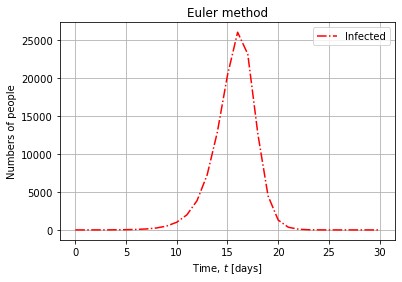

In [84]:
plt.figure()

plt.title("Euler method")
#plt.plot(t, X_euler[:,0], color = 'orange', linestyle = '-.', label='Susceptible')
plt.plot(t, X_euler[:,1], 'r-.', label='Infected')
#plt.plot(t, X_euler[:,2], 'g-.', label='Recovered with immunity')
plt.grid()
plt.xlabel("Time, $t$ [days]")
plt.ylabel("Numbers of people")
plt.legend(loc = "best")

plt.show();

For those parameter values, when does the number of infected people peak? (2 points) How many people are infected at the peak? (3 points). (Have your code identify these things; don't do it manually.)

In [10]:
max_peple_infected = max(X_euler[:,1])
max_peple_infected

26033.391521237274

In [11]:
r = list(X_euler[:,1])
day_max = r.index(max(r))
day_max

16

The maximum number of infected people is 26,033 and it occurs at day 16.

Unfortunately, for new diseases, we may not know 
β
 or 
γ
 with much accuracy. Vary these two variables over "nearby" values, and plot on a heat map how the time of the peak of the infection depends on these two variables. (5 points). Do the same for the number of individuals infected at peak. (5 points)

In [151]:
import random
N = 134000 #New Haven population
I0, R0 = 1., 0 #Initial number of infected and recovered individuals
S0 = N - I0 - R0 #Susceptible individuals to infection initially is deduced
beta, gamma = random.randrange(3), random.randrange(3) #Contact rate and mean recovery rate
tmax = 30 #A grid of time points (in days)
Nt = 30
t = np.linspace(0, tmax, Nt+1)
X0 = S0, I0, R0 #Initial conditions vector
X_euler = explicit_euler(derivative, X0, t)

In [ ]:
beta = random.randrange(3)
gamma = random.randrange(3)

In [238]:
cc[0][0]

0

In [314]:
from itertools import permutations
# Let's take all the possible combinations of beta,gamma = 0,1,2 or 3
arr = [0, 1, 2, 3]
cc = list(permutations(arr,2))
cc.insert(0, (0,0))
cc.insert(5, (1,1))
cc.insert(10, (2,2))
cc.insert(15, (3,3))
cc

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [318]:
#Let's use euler for all possible values of beta, gamma and create a dataframe of the results
col_ = []
for i in range(len(cc)):
    beta, gamma = cc[i][0], cc[i][1]
    X_euler = explicit_euler(derivative, X0, t)
    day_max = list(X_euler[:,1]).index(max(list(X_euler[:,1])))
    col_.append(day_max)


df = pd.DataFrame({'day_max': col_, 'beta,gamma': cc})
df

,day_max,"beta,gamma"
0,0,"(0, 0)"
1,0,"(0, 1)"
2,0,"(0, 2)"
3,30,"(0, 3)"
4,23,"(1, 0)"
5,0,"(1, 1)"
6,0,"(1, 2)"
7,30,"(1, 3)"
8,12,"(2, 0)"
9,16,"(2, 1)"


In [293]:
beta = np.array(cc)[:,0]
gamma = np.array(cc)[:,1]
y_beta = np.reshape(beta, (4, 4)).T
y_gamma = np.reshape(gamma, (4, 4)).T

In [316]:
#Let's rechape the values obtained with euler method into a (4,4) matrix: 
#I used the transpose of the matrix for correct display of the results into the heatmap
x = np.reshape(col_, (4, 4)).T
x

array([[ 0, 23, 12, 30],
       [ 0,  0, 16, 11],
       [ 0,  0,  0, 15],
       [30, 30,  0,  0]])

<AxesSubplot:>

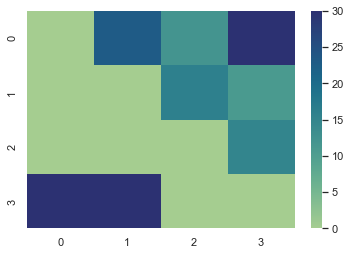

In [317]:
sns.heatmap(x, cmap="crest")

# Exercise 4

Identify a data set online (5 points) that you find interesting that could potentially be used for the final project; the main requirements is that there needs to be many (hundreds or more) data items with several identifiable variables, at least one of which could be viewed as an output variable that you could predict from the others.

Describe the dataset (5 points) Your answer should address (but not be limited to): how many variables? Are the key variables explicitly specified or are they things you would have to derive (e.g. by inferring from text)? Are any of the variables exactly derivable from other variables? (i.e. are any of them redundant?) Are there any variables that could in principle be statistically predicted from other variables? How many rows/data points are there? Is the data in a standard format? If not, how could you convert it to a standard format?

Describe the terms of use and identify any key restrictions (e.g. do you have to officially apply to get access to the data? Are there certain types of analyses you can't do?) (5 points) 

Remember: if you can't find explicit permission to use a given dataset, assume that you cannot do so.

In [532]:
data = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [485]:
data.columns

Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [533]:
data

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [534]:
data.describe()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.094186,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.296921,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.292087,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.698160,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


The DataFrame above seems quite reasonable for this problem. Indeed, it contains 253,680 rows and 22 columns. In addition, the first column (Heart Disease or Attack) could represent the output (the predictive column from the other columns)

In the data above, many adjustments could be made. For instance, some standardization method could help us to assign some columns to binary classification. Indeed, so far, if I want to implement ML models to predict Heart Disease, some columns like BMI, GenHealth, Age, Education and Income would weight more than others. 

Moreover, it might be interesting to find a coherent method to merge some subcategories into a same category to simplify any computing model (e.g., fruit and veggies into healthy alimentation)

Last but not least, I don't see any N/A value on tail and head but it is worth investigate in that and drop.na for any undesired row or use other methods to replace the data (e.g., linear regression). Similarly, we have to drop all the duplicates as well when pre-processing the data. 

Furthermore, it might be interesting to see how much overlapping occur for some columns that seem to be quite correlated such as BMI and PhysAct, PhysHealth, Fruit, Veggies. If we have a correlation close to 1, we could drop some columns to prevent any predictive model from overlapping. 

It is important to notice that the dataset above is open for public (Public domain) under the licence CC0.

Do data exploration on the dataset, and present a representative set of figures that gives insight into the data. Comment on the insights gained. (5 points)

Identify any data cleaning needs (this includes checking for missing data) and write code to perform them. If the data does not need to be cleaned, explain how you reached this conclusion. (5 points)

In [535]:
data = data.dropna(axis=0)
data

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


There is no NA value in the dataframe

Let's see if we have duplicates

In [536]:
duplicated_ = data[data.duplicated()]
duplicated_

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
1242,0.0,1.0,1.0,1.0,27.0,1.0,0.0,2.0,0.0,0.0,...,1.0,0.0,5.0,0.0,30.0,1.0,0.0,10.0,4.0,5.0
1563,0.0,0.0,0.0,1.0,21.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
2700,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
3160,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
3332,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253492,0.0,1.0,1.0,1.0,33.0,0.0,0.0,2.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,9.0,6.0,6.0
253550,0.0,0.0,0.0,1.0,25.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,6.0,8.0
253563,0.0,0.0,1.0,1.0,24.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,6.0,8.0
253597,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0


We have 23, 899 duplicates.. that's a lot! (it represents almost 10% of our dataset!). Let's drop the duplicates:

In [537]:
data.loc[data.duplicated(), :]
data.drop_duplicates(inplace=True)
data

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


Let's evaluate the correlation between each feature using a heatmap to see if we could merge or drop some columns

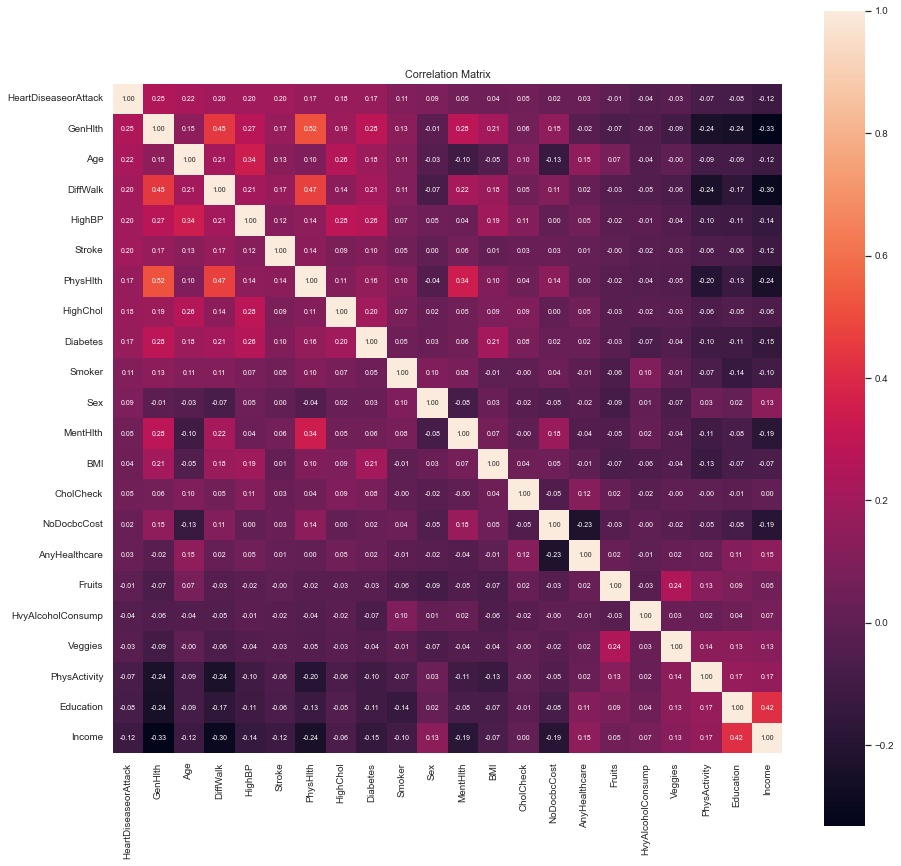

In [538]:
import seaborn as sns
correlation_matrix = data.corr()
k = 22 # number of columns
index_ = correlation_matrix.nlargest(k,'HeartDiseaseorAttack')['HeartDiseaseorAttack'].index
correlation_matrix = np.corrcoef(data[cols].values.T)
sns.set(font_scale=.9)
fig, ax = plt.subplots(figsize=(15,15))  
heatmap = sns.heatmap(correlation_matrix,xticklabels=cols.values, yticklabels=cols.values, annot_kws={'size': 7},  annot=True, cbar=True, ax=ax, square=True, fmt='.02f')
plt.title("Correlation Matrix")
plt.show()

As expected, some of the features are highly correlated which can negatively impact our predictions. For instance education and income have a correlation coeff of 0.4. Also, PhysHealth is highly correlated to GenHealth and DiffWalk (coeff of 0.5). Also, some of the features have a very low correlation with our predictor HeartDisease. For instance, education have only a 0.05 correlation coefficient with HeartDisease and is highly correlated to HeartDisease. To optimize the accuracy of our predictive model it might be worth dropping the column. 

In addition, we can drop HeartDiseaseorAttack from the dataframe and assign it to y for y_train 

In [543]:
y = data['HeartDiseaseorAttack']
data.drop(columns=['Education', 'HeartDiseaseorAttack'])

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,7.0
253676,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,4.0
253677,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0
253678,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,1.0


Let's see how y is distributed

In [585]:
y.value_counts()

0.0    206064
1.0     23717
Name: HeartDiseaseorAttack, dtype: int64

Only 10% of the patients had a heart attack or stroke. It is quite low. Though, there are some methods that could be used when developing ML algorithms to train the data on sufficiently high amounts of data points (such as leave one out cross validation method). We can represent the imbalanced count as:

Text(0.5, 0, 'Heart Disease or Attack')

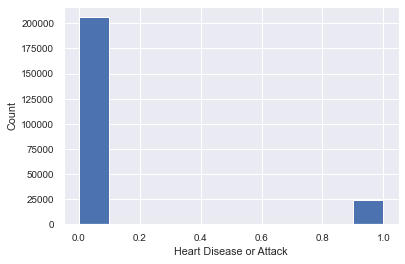

In [588]:
plt.hist(y, density=False) 
plt.ylabel('Count')
plt.xlabel('Heart Disease or Attack')

In [4]:
X

NameError: name 'X' is not defined